In [1]:
import hdbscan
import umap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups


/Users/faustogerman/miniforge3/envs/PekinSearch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RAW_DATA = pd.read_csv("./test_data.csv")
data = list(RAW_DATA["text"])

## Generate word embeddings from corpus

In [3]:
model = SentenceTransformer('sentence-transformers/paraphrase-albert-small-v2')
embeddings = model.encode(data, show_progress_bar=True)

Batches: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


## Lower the dimensionality of word embeddings

In [4]:
umap_model = umap.UMAP(
    n_neighbors=6,
    n_components=5,
    metric='cosine',
    random_state=42
).fit(embeddings)

umap_embeddings = umap_model.transform(embeddings)

## Cluster the embeddings

In [5]:
cluster = hdbscan.HDBSCAN(
    min_cluster_size=3,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,
).fit(umap_embeddings)

In [6]:
# Return a cluster label for each of the documents
# A label of -1 means that the document is an outlier
cluster.labels_

array([3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 0, 0,
       3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 3, 2, 3, 3, 3, 3, 1, 3, 3,
       3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3])

In [7]:
# Return a cluster label for each of the documents
# A label of -1 means that the document is an outlier
np.unique(cluster.labels_)

array([0, 1, 2, 3])

## Visualize the clusters in 2-dimensions

This is only for visualization purposes. The model and clusters used for the rest of the experiment are defined above.


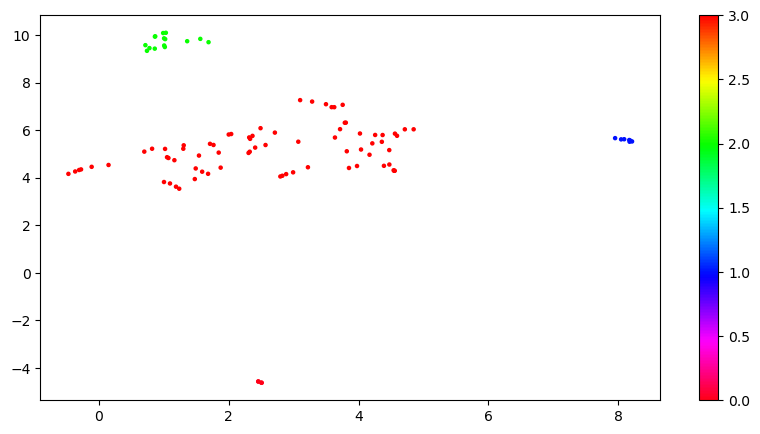

In [8]:
# Prepare data
umap_data = umap.UMAP(
    n_neighbors=6,
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=1
).fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5, cmap='hsv_r')
plt.colorbar()

## Group the Documents into Their Clusters


In [9]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index=False).agg({'Doc': ' '.join})

In [10]:
docs_per_topic

,Topic,Doc
0,0,RT @OkroguLes: There are 2 differences in this...
1,1,RT @Grahampoo: The light this evening in south...
2,2,RT @GiveawayBase: Enter for a #chance to #win ...
3,3,RT @appleinsider: How To Create and Share Cale...


## Create Class-Based TF-IDF Matrix (c-TF-IDF)

The difference between regular TF-IDF and Class-Based TF-IDF is that with c-TF-IDF we join the documents in each class (cluster) and teat the cluster as one big document.


In [11]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(
        ngram_range=ngram_range,
        stop_words="english"
    ).fit(documents)
    
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count


tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [12]:
tf_idf.shape  # (number of words, number of clusters)

(872, 4)

## Extract the Relevant Words in Each Cluster


In [13]:
# Get the most important words in each of the clusters
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j])
                           for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words


# How many documents are in each cluster
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes


top_n_words = extract_top_n_words_per_topic(
    tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)


/Users/faustogerman/miniforge3/envs/PekinSearch/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
3,3,74
2,2,15
1,1,7
0,0,4


## Show the Words


### Cluster #1

In [14]:
sorted(top_n_words[0], key=lambda x: x[1], reverse=True)

[('cloth', 0.2886547022066578),
 ('polishing', 0.2886547022066578),
 ('differences', 0.18393576142104004),
 ('cost', 0.18393576142104004),
 ('logo', 0.18393576142104004),
 ('doesn', 0.17118470134594233),
 ('vs', 0.16076632667200208),
 ('clean', 0.11177208586937559),
 ('microfibercloth', 0.11177208586937559),
 ('okrogules', 0.11177208586937559),
 ('shine', 0.11177208586937559),
 ('cleanmytech', 0.11177208586937559),
 ('polishingcloth', 0.11177208586937559),
 ('applepolishingcloth', 0.11177208586937559),
 ('99', 0.09196788071052002),
 ('5h6wuunyww', 0.06578814551411559),
 ('5h6wuug8ae', 0.06578814551411559),
 ('uyy2i3etux', 0.06578814551411559),
 ('rt', 0.02547423197953667),
 ('apple', 0.02321698992825356)]

### Cluster #2

In [15]:
sorted(top_n_words[1], key=lambda x: x[1], reverse=True)

[('10', 0.17402540516041462),
 ('7mqe', 0.10845024424700975),
 ('rud09zkncl', 0.10845024424700975),
 ('quick', 0.10845024424700975),
 ('hampshire', 0.10845024424700975),
 ('happypines', 0.10845024424700975),
 ('sunset', 0.10845024424700975),
 ('light', 0.10845024424700975),
 ('lightning', 0.10845024424700975),
 ('southern', 0.10845024424700975),
 ('spin', 0.10845024424700975),
 ('tonight', 0.10845024424700975),
 ('evening', 0.10845024424700975),
 ('jacobincambodia', 0.10845024424700975),
 ('cambodia', 0.10845024424700975),
 ('riding', 0.10845024424700975),
 ('captured', 0.10845024424700975),
 ('storm', 0.10845024424700975),
 ('work', 0.09955286056293404),
 ('grahampoo', 0.08066026815315765)]

### Cluster #3

In [16]:
sorted(top_n_words[2], key=lambda x: x[1], reverse=True)

[('iphonecase', 0.0874635455987576),
 ('phonecases', 0.0874635455987576),
 ('findyourthing', 0.07760964439259044),
 ('moms', 0.07760964439259044),
 ('dkent7673', 0.07760964439259044),
 ('totebags', 0.06671245232887463),
 ('cases', 0.06671245232887463),
 ('iphone', 0.05529920817050671),
 ('tshirt', 0.05450608130549194),
 ('rt', 0.050816473119801135),
 ('iphone14', 0.050034339246655964),
 ('giveaway', 0.040539098501846074),
 ('tees', 0.040539098501846074),
 ('case', 0.033356226164437314),
 ('andriod', 0.02386098541962742),
 ('assisted', 0.02386098541962742),
 ('sneaker', 0.02386098541962742),
 ('solar', 0.02386098541962742),
 ('uglybrosnft', 0.02386098541962742),
 ('murder', 0.02386098541962742)]

### Cluster #4

In [17]:
sorted(top_n_words[3], key=lambda x: x[1], reverse=True)

[('ios', 0.025102540119022566),
 ('16', 0.022638663304127463),
 ('security', 0.0193158504734184),
 ('new', 0.01749481110976907),
 ('iphone', 0.016328173271078567),
 ('google', 0.016074645309837744),
 ('update', 0.016074645309837744),
 ('rt', 0.015604740353415462),
 ('ios16', 0.014808926219991605),
 ('pro', 0.014654479509906419),
 ('tech', 0.014065314646108027),
 ('gt', 0.013429168099093253),
 ('response', 0.013429168099093253),
 ('ipad', 0.013429168099093253),
 ('twitter', 0.011916198383269653),
 ('news', 0.011916198383269653),
 ('beta', 0.011916198383269653),
 ('users', 0.011916198383269653),
 ('like', 0.011190973415911045),
 ('amazon', 0.010243041606581387)]